In [1]:
import cv2
import numpy as np
from scipy.ndimage import convolve, median_filter, gaussian_filter1d
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import time

Lucas Kanade

First we detect the top N corners with Shi Tomasi corner detector (goodFeaturesToTrack in OpenCV)

$$
R = min(\lambda_1 \lambda_2) 
\\\text{ where if R is greater than a specified threshold then its classified as a corner}
$$

Then for each corner detected, we calculate the optical flow for a 3x3 neighborhood around it

$$
I(x + dx, y +dy, t+ dt) = I(x,y,t) + 
\frac{\partial I}{\partial x}dx + \frac{\partial I}{\partial y}dy + \frac{\partial I}{\partial t} dt
$$

And since the Farneback method inherently provides a vector field, extracting global motion parameters is unnecessary

In [3]:
def estimate_global_motion_dense(prev_gray, curr_gray):
    """
    Compute global motion using dense optical flow.
    Returns an affine transformation matrix.
    """
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    flow_x = flow[..., 0]
    flow_y = flow[..., 1]

    # Compute the median flow as translation
    median_flow_x = np.median(flow_x)
    median_flow_y = np.median(flow_y)

    # Create an affine transformation matrix
    affine_matrix = np.array([
        [1, 0, median_flow_x],  # Horizontal motion
        [0, 1, median_flow_y]   # Vertical motion
    ], dtype=np.float32)
    
    return affine_matrix, (median_flow_x, median_flow_y)

with Gaussian filter

$$
G(x,y) = \frac{1}{2 \pi \sigma^2} \exp(- \frac{x^2+y^2}{2 \sigma^2})
$$

In [5]:
def compute_motion(prev_gray, curr_gray):
    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    # Calculate median motion
    dx = np.median(flow[..., 0])
    dy = np.median(flow[..., 1])
    return dx, dy

In [7]:
def smooth_trajectory(trajectory, sigma=5):
    smoothed_trajectory = gaussian_filter1d(trajectory, sigma=sigma, axis=0)
    return smoothed_trajectory

In [9]:
def warp_frame(frame, affine_matrix):
    h, w = frame.shape[:2]
    return cv2.warpAffine(frame, affine_matrix, (w, h))

In [11]:
def calculate_mse_psnr(original, stabilized):
    mse = np.mean((original - stabilized) ** 2)
    if mse == 0:
        return mse, float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return mse, psnr

In [13]:
def stabilize_video(input_path, output_path, downsample_factor=0.5, smoothing_sigma=5):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return
    
    # Downsample dimensions
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) * downsample_factor)
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * downsample_factor)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    # Read the first frame
    _, prev_frame = cap.read()
    if prev_frame is None:
        print("Error: Cannot read the first frame.")
        cap.release()
        return
    
    # Downsample and convert to grayscale
    prev_frame = cv2.resize(prev_frame, (frame_width, frame_height))
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    
    motions = []
    mses = []
    psnrs = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Downsample and convert to grayscale
        frame = cv2.resize(frame, (frame_width, frame_height))
        curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Compute affine transformation matrix for motion
        affine_matrix, motion = estimate_global_motion_dense(prev_gray, curr_gray)
        motions.append(motion)
        
        # Warp the frame based on the computed affine matrix
        stabilized_frame = warp_frame(frame, affine_matrix)
        out.write(stabilized_frame)
        
        # Compute metrics: MSE and PSNR
        mse = np.mean((curr_gray.astype(float) - prev_gray.astype(float)) ** 2)
        mses.append(mse)
        
        if mse > 0:
            psnr = 10 * np.log10(255**2 / mse)
        else:
            psnr = 100  # Ideal PSNR for zero error
        psnrs.append(psnr)
        
        # Update the previous frame
        prev_gray = curr_gray
    
    cap.release()
    out.release()
    
    # Convert motion lists to numpy arrays for plotting
    motions = np.array(motions)
    smoothed_motions = smooth_trajectory(motions, sigma=smoothing_sigma)
    
    # Plot Trajectories and Metrics
    plt.figure(figsize=(10, 6))

    # X Trajectory
    plt.subplot(2, 2, 1)
    plt.plot(motions[:, 0], label='Original X Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 0], label='Smoothed X Trajectory', color='darkorange')
    plt.title('X Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('X Translation')
    plt.legend()

    # Y Trajectory
    plt.subplot(2, 2, 2)
    plt.plot(motions[:, 1], label='Original Y Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 1], label='Smoothed Y Trajectory', color='darkorange')
    plt.title('Y Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('Y Translation')
    plt.legend()

    # Plot MSE
    plt.subplot(2, 2, 3)
    plt.plot(mses, label='MSE', color='green')
    plt.title('Mean Squared Error (MSE)')
    plt.xlabel('Frame')
    plt.ylabel('MSE')

    # Plot PSNR
    plt.subplot(2, 2, 4)
    plt.plot(psnrs, label='PSNR', color='orange')
    plt.title('Peak Signal-to-Noise Ratio (PSNR)')
    plt.xlabel('Frame')
    plt.ylabel('PSNR (dB)')

    plt.tight_layout()
    plt.show()
    print("Video stabilization complete and saved at:", output_path)
    
    # Convert motion lists to numpy arrays for plotting
    motions = np.array(motions)
    smoothed_motions = motions  # For now, smoothed and original are identical
    
    # Plot Trajectories and Metrics
    plt.figure(figsize=(10, 6))



In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\video.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_gaussian.mp4"
stabilize_video(input_video_path, output_video_path)

In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\4.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_Dense_gaussian_4.mp4"
stabilize_video(input_video_path, output_video_path)

In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\4.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_gaussian_4.mp4"
stabilize_video(input_video_path, output_video_path)

In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\5.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_gaussian_5.mp4"
stabilize_video(input_video_path, output_video_path)

In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\6.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_gaussian_6.mp4"
stabilize_video(input_video_path, output_video_path)

In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\7.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_gaussian_7.mp4"
stabilize_video(input_video_path, output_video_path)

In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\football_CIF.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_gaussian_football_CIF.mp4"
stabilize_video(input_video_path, output_video_path)

In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\rabbit.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_gaussian_rabbit.mp4"
stabilize_video(input_video_path, output_video_path)

with moving average filter

In [ ]:
def average_filter_motion(motions, window_size=5):
    smoothed_motions = np.copy(motions)
    for i in range(motions.shape[1]):
        smoothed_motions[:, i] = np.convolve(motions[:, i], np.ones(window_size) / window_size, mode='same')
    return smoothed_motions


In [ ]:
def stabilize_video(input_path, output_path, downsample_factor=0.5, smoothing_sigma=5):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return
    
    # Downsample dimensions
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) * downsample_factor)
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * downsample_factor)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    # Read the first frame
    _, prev_frame = cap.read()
    if prev_frame is None:
        print("Error: Cannot read the first frame.")
        cap.release()
        return
    
    # Downsample and convert to grayscale
    prev_frame = cv2.resize(prev_frame, (frame_width, frame_height))
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    
    motions = []
    mses = []
    psnrs = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Downsample and convert to grayscale
        frame = cv2.resize(frame, (frame_width, frame_height))
        curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Compute affine transformation matrix for motion
        affine_matrix, motion = estimate_global_motion_dense(prev_gray, curr_gray)
        motions.append(motion)
        
        # Warp the frame based on the computed affine matrix
        stabilized_frame = warp_frame(frame, affine_matrix)
        out.write(stabilized_frame)
        
        # Compute metrics: MSE and PSNR
        mse = np.mean((curr_gray.astype(float) - prev_gray.astype(float)) ** 2)
        mses.append(mse)
        
        if mse > 0:
            psnr = 10 * np.log10(255**2 / mse)
        else:
            psnr = 100  # Ideal PSNR for zero error
        psnrs.append(psnr)
        
        # Update the previous frame
        prev_gray = curr_gray
    
    cap.release()
    out.release()
    
    # Convert motion lists to numpy arrays for plotting
    motions = np.array(motions)
    smoothed_motions = average_filter_motion(motions)
    
    # Plot Trajectories and Metrics
    plt.figure(figsize=(10, 6))

    # X Trajectory
    plt.subplot(2, 2, 1)
    plt.plot(motions[:, 0], label='Original X Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 0], label='Smoothed X Trajectory', color='darkorange')
    plt.title('X Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('X Translation')
    plt.legend()

    # Y Trajectory
    plt.subplot(2, 2, 2)
    plt.plot(motions[:, 1], label='Original Y Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 1], label='Smoothed Y Trajectory', color='darkorange')
    plt.title('Y Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('Y Translation')
    plt.legend()

    # Plot MSE
    plt.subplot(2, 2, 3)
    plt.plot(mses, label='MSE', color='green')
    plt.title('Mean Squared Error (MSE)')
    plt.xlabel('Frame')
    plt.ylabel('MSE')

    # Plot PSNR
    plt.subplot(2, 2, 4)
    plt.plot(psnrs, label='PSNR', color='orange')
    plt.title('Peak Signal-to-Noise Ratio (PSNR)')
    plt.xlabel('Frame')
    plt.ylabel('PSNR (dB)')

    plt.tight_layout()
    plt.show()
    print("Video stabilization complete and saved at:", output_path)
    
    # Convert motion lists to numpy arrays for plotting
    motions = np.array(motions)
    smoothed_motions = motions  # For now, smoothed and original are identical
    
    # Plot Trajectories and Metrics
    plt.figure(figsize=(10, 6))



In [ ]:

input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\video.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_avg_video.mp4"
stabilize_video(input_video_path, output_video_path)


In [ ]:

input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\4.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_avg_4.mp4"
stabilize_video(input_video_path, output_video_path)


In [ ]:

input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\5.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_avg_5.mp4"
stabilize_video(input_video_path, output_video_path)


In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\6.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_avg_6.mp4"
stabilize_video(input_video_path, output_video_path)


In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\7.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_avg_7.mp4"
stabilize_video(input_video_path, output_video_path)


In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\football_CIF.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_avg_football_CIF.mp4"
stabilize_video(input_video_path, output_video_path)


In [ ]:
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\rabbit.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_avg.mp4"
stabilize_video(input_video_path, output_video_path)

Median

In [15]:
def median_filter_motion(motions, kernel_size=5):
    smoothed_motions = np.copy(motions)
    smoothed_motions[:, 0] = medfilt(motions[:, 0], kernel_size=kernel_size)
    smoothed_motions[:, 1] = medfilt(motions[:, 1], kernel_size=kernel_size)
    return smoothed_motions

In [17]:
def calculate_mse_psnr(original, stabilized):
    mse = np.mean((original - stabilized) ** 2)
    if mse == 0:
        return mse, float('inf')  # PSNR is infinite for identical frames
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    return mse, psnr

In [18]:
def stabilize_video(input_path, output_path, downsample_factor=0.5, smoothing_sigma=5):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return
    
    # Downsample dimensions
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) * downsample_factor)
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * downsample_factor)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    # Read the first frame
    _, prev_frame = cap.read()
    if prev_frame is None:
        print("Error: Cannot read the first frame.")
        cap.release()
        return
    
    # Downsample and convert to grayscale
    prev_frame = cv2.resize(prev_frame, (frame_width, frame_height))
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    
    motions = []
    mses = []
    psnrs = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Downsample and convert to grayscale
        frame = cv2.resize(frame, (frame_width, frame_height))
        curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Compute affine transformation matrix for motion
        affine_matrix, motion = estimate_global_motion_dense(prev_gray, curr_gray)
        motions.append(motion)
        
        # Warp the frame based on the computed affine matrix
        stabilized_frame = warp_frame(frame, affine_matrix)
        out.write(stabilized_frame)
        
        # Compute metrics: MSE and PSNR
        mse = np.mean((curr_gray.astype(float) - prev_gray.astype(float)) ** 2)
        mses.append(mse)
        
        if mse > 0:
            psnr = 10 * np.log10(255**2 / mse)
        else:
            psnr = 100  # Ideal PSNR for zero error
        psnrs.append(psnr)
        
        # Update the previous frame
        prev_gray = curr_gray
    
    cap.release()
    out.release()
    
    # Convert motion lists to numpy arrays for plotting
    motions = np.array(motions)
    smoothed_motions = median_filter_motion(motions)
    
    # Plot Trajectories and Metrics
    plt.figure(figsize=(10, 6))

    # X Trajectory
    plt.subplot(2, 2, 1)
    plt.plot(motions[:, 0], label='Original X Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 0], label='Smoothed X Trajectory', color='darkorange')
    plt.title('X Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('X Translation')
    plt.legend()

    # Y Trajectory
    plt.subplot(2, 2, 2)
    plt.plot(motions[:, 1], label='Original Y Trajectory', color='royalblue')
    plt.plot(smoothed_motions[:, 1], label='Smoothed Y Trajectory', color='darkorange')
    plt.title('Y Trajectory')
    plt.xlabel('Frame')
    plt.ylabel('Y Translation')
    plt.legend()

    # Plot MSE
    plt.subplot(2, 2, 3)
    plt.plot(mses, label='MSE', color='green')
    plt.title('Mean Squared Error (MSE)')
    plt.xlabel('Frame')
    plt.ylabel('MSE')

    # Plot PSNR
    plt.subplot(2, 2, 4)
    plt.plot(psnrs, label='PSNR', color='orange')
    plt.title('Peak Signal-to-Noise Ratio (PSNR)')
    plt.xlabel('Frame')
    plt.ylabel('PSNR (dB)')

    plt.tight_layout()
    plt.show()
    print("Video stabilization complete and saved at:", output_path)
    
    # Convert motion lists to numpy arrays for plotting
    motions = np.array(motions)
    smoothed_motions = motions  # For now, smoothed and original are identical
    
    # Plot Trajectories and Metrics
    plt.figure(figsize=(10, 6))



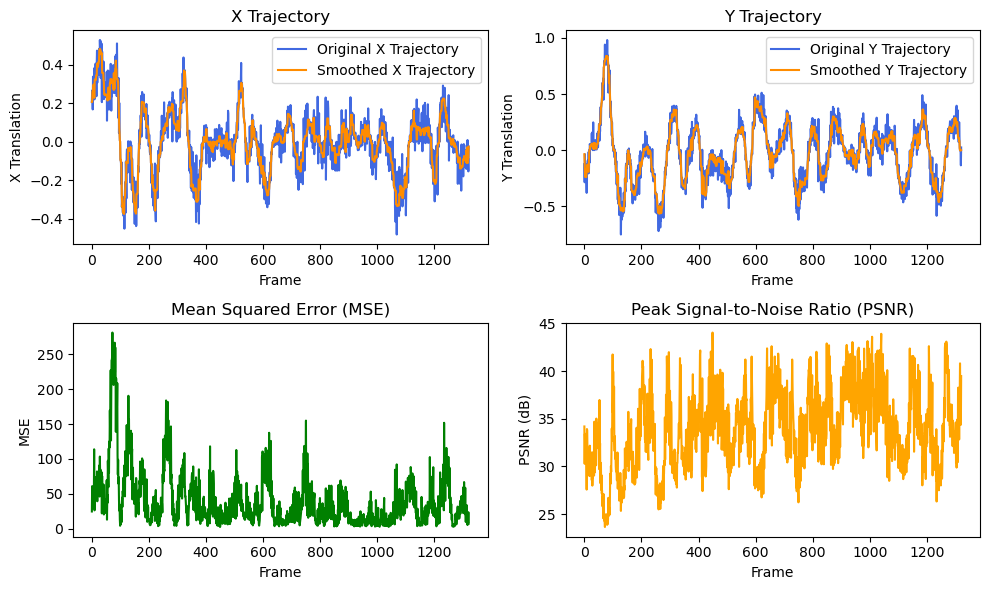

Video stabilization complete and saved at: E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median.mp4
CPU times: total: 26.7 s
Wall time: 24.4 s


<Figure size 1000x600 with 0 Axes>

In [19]:
%%time
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\video.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median.mp4"
stabilize_video(input_video_path, output_video_path)

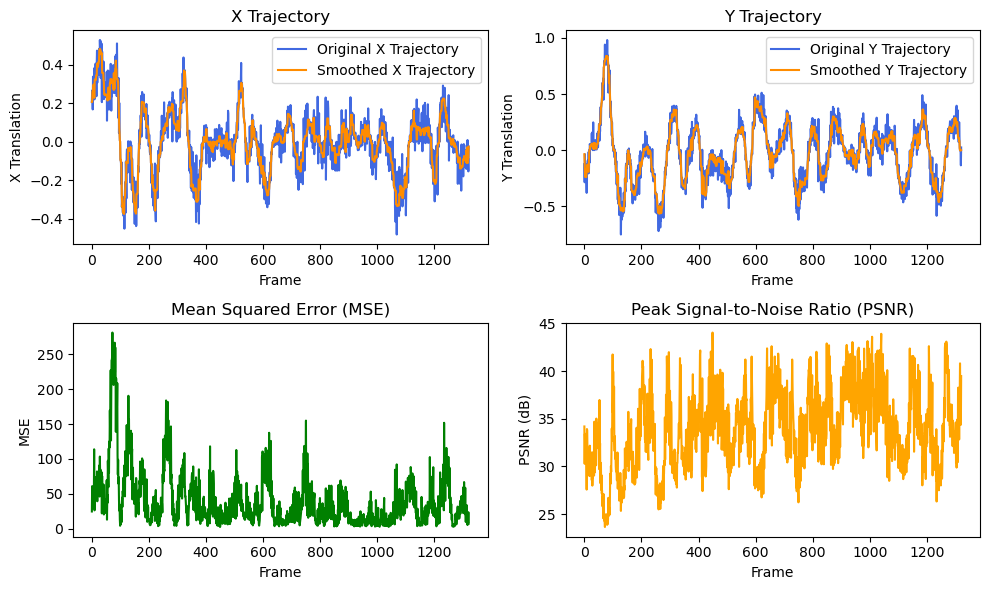

Video stabilization complete and saved at: E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_video.mp4
CPU times: total: 26.7 s
Wall time: 24.1 s


<Figure size 1000x600 with 0 Axes>

In [20]:
%%time
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\video.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_video.mp4"
stabilize_video(input_video_path, output_video_path)


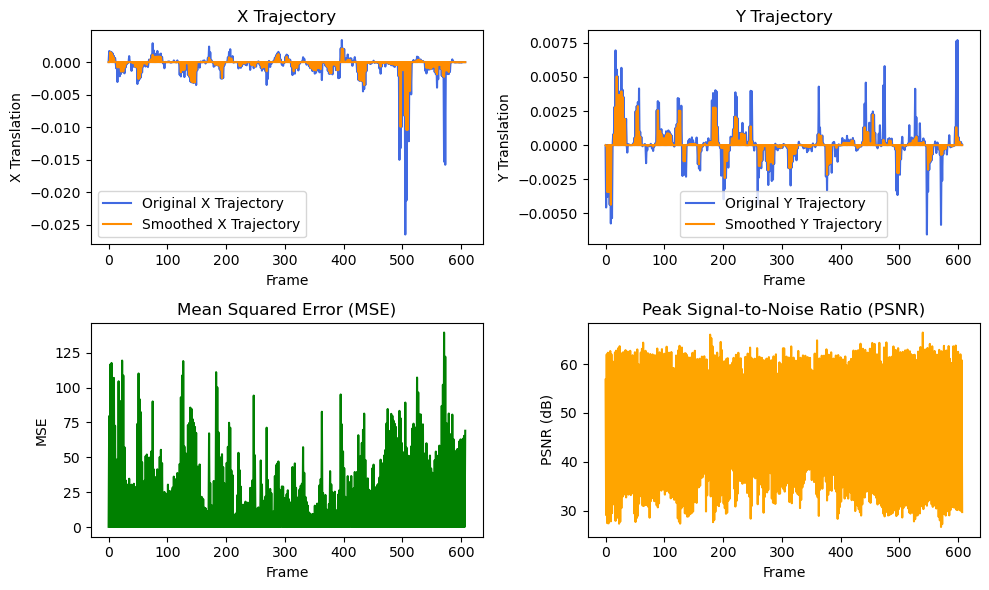

Video stabilization complete and saved at: E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_4.mp4
CPU times: total: 1min 39s
Wall time: 1min 5s


<Figure size 1000x600 with 0 Axes>

In [23]:
%%time
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\4.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_4.mp4"
stabilize_video(input_video_path, output_video_path)


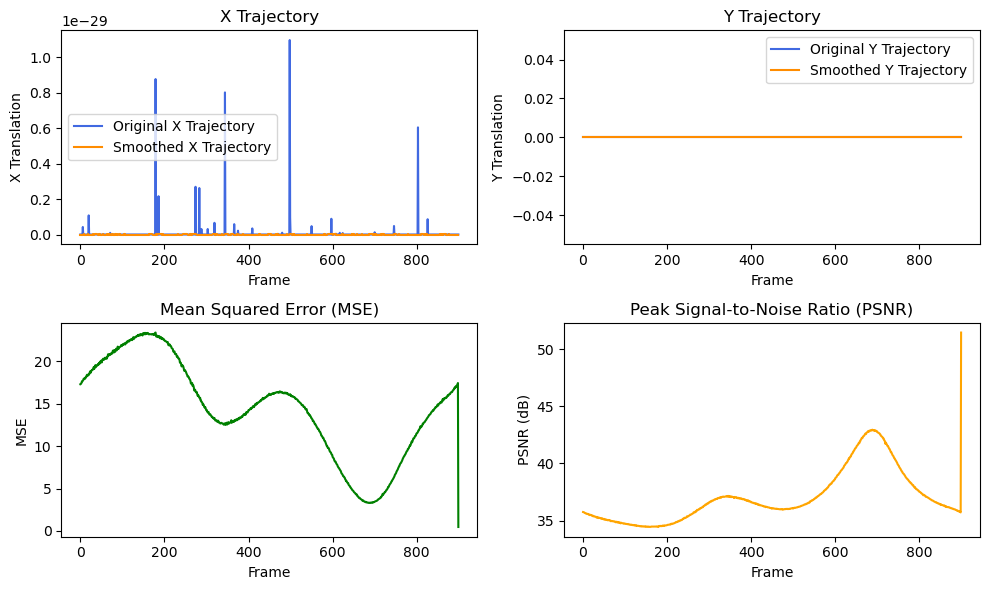

Video stabilization complete and saved at: E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_5.mp4
CPU times: total: 2min 19s
Wall time: 1min 32s


<Figure size 1000x600 with 0 Axes>

In [24]:
%%time
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\5.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_5.mp4"
stabilize_video(input_video_path, output_video_path)


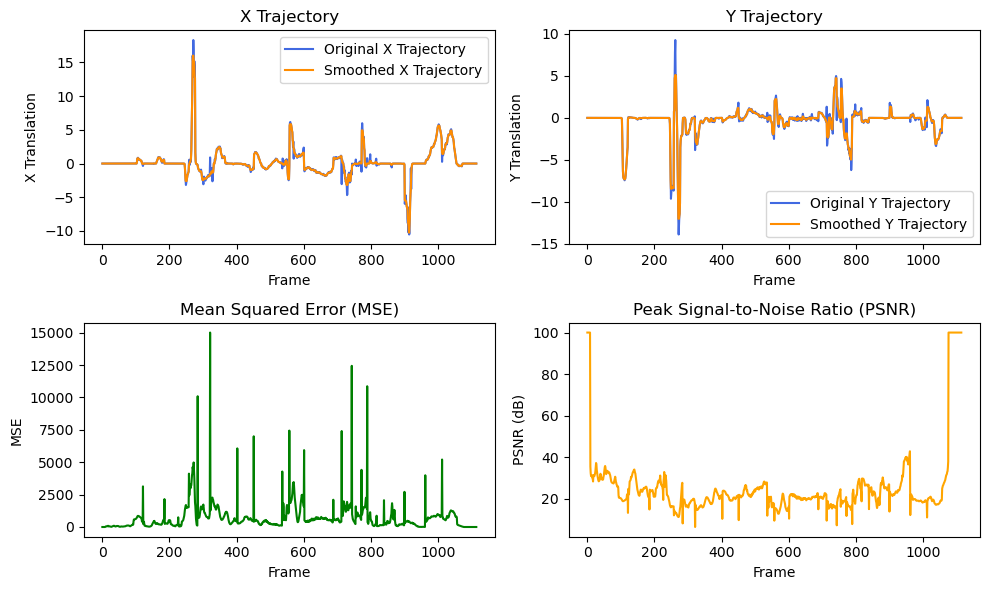

Video stabilization complete and saved at: E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_6.mp4
CPU times: total: 23.8 s
Wall time: 21 s


<Figure size 1000x600 with 0 Axes>

In [25]:
%%time
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\6.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_6.mp4"
stabilize_video(input_video_path, output_video_path)


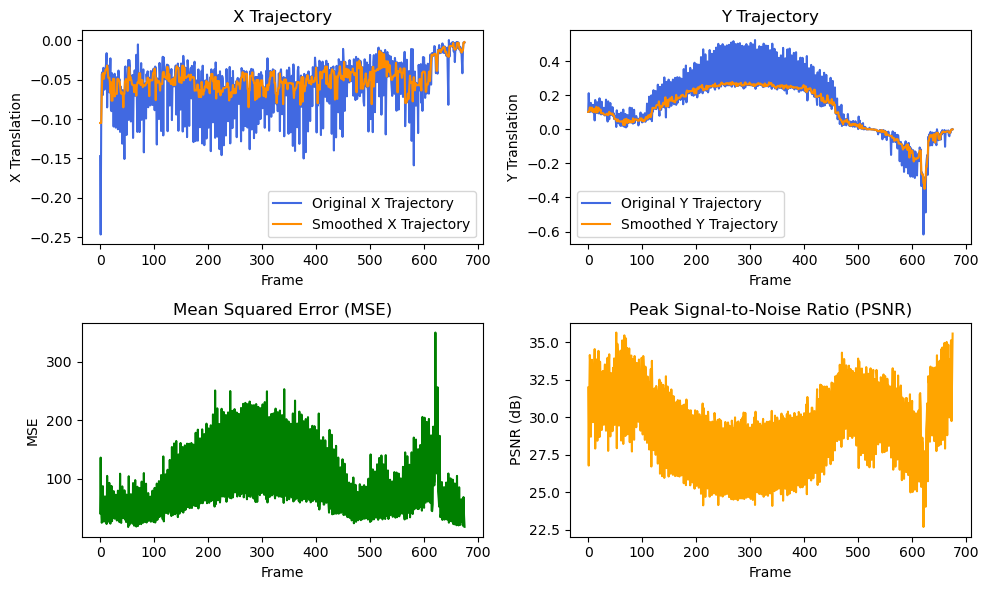

Video stabilization complete and saved at: E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_7.mp4
CPU times: total: 51 s
Wall time: 32.4 s


<Figure size 1000x600 with 0 Axes>

In [26]:
%%time
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\7.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_7.mp4"
stabilize_video(input_video_path, output_video_path)


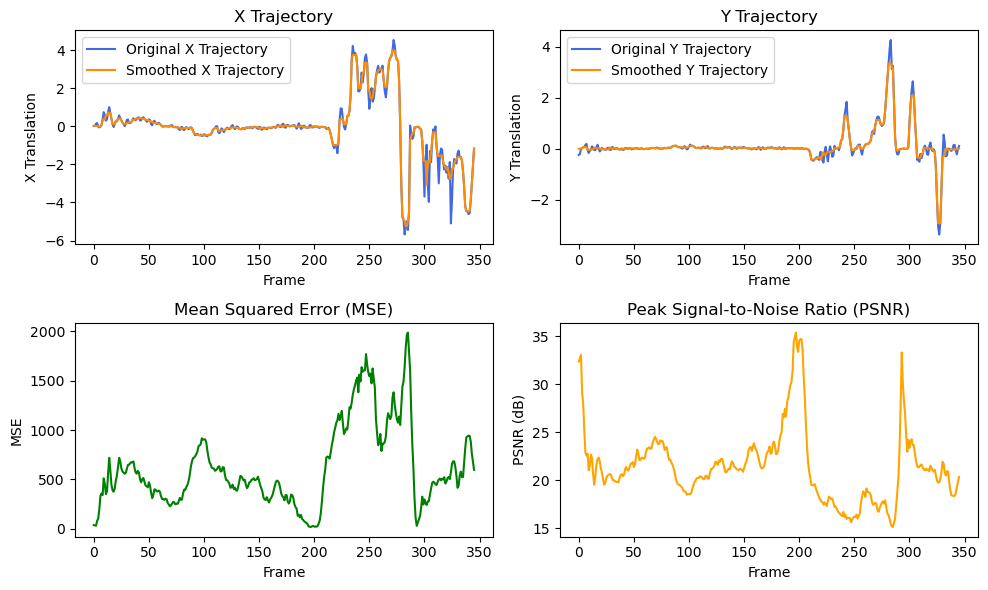

Video stabilization complete and saved at: E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_football_CIF.mp4
CPU times: total: 2.14 s
Wall time: 1.82 s


<Figure size 1000x600 with 0 Axes>

In [27]:
%%time
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\football_CIF.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_football_CIF.mp4"
stabilize_video(input_video_path, output_video_path)


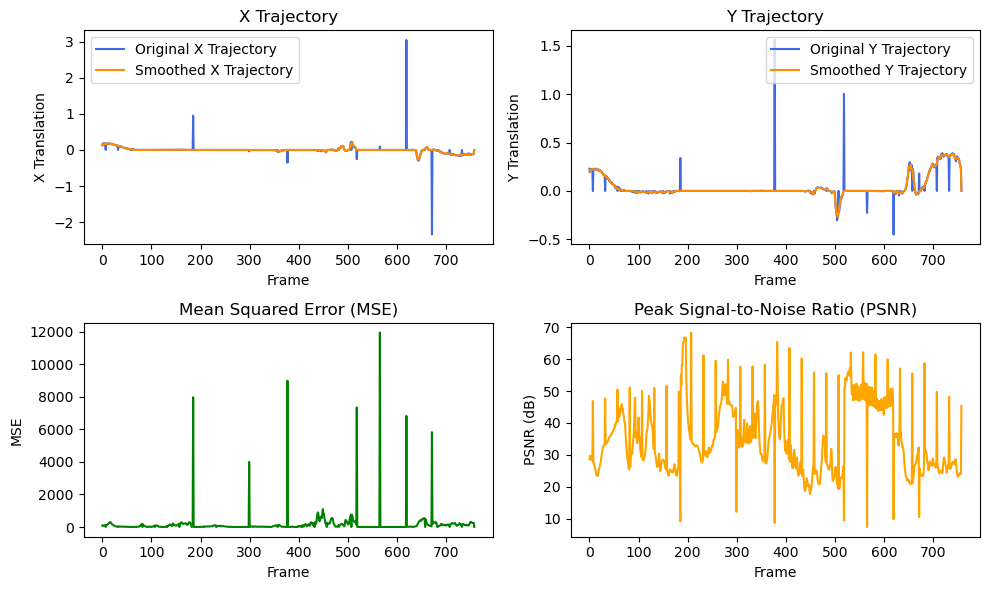

Video stabilization complete and saved at: E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_rabbit.mp4
CPU times: total: 9.14 s
Wall time: 8.73 s


<Figure size 1000x600 with 0 Axes>

In [28]:
%%time
input_video_path = r"E:\Fall 2024\Image and Video Processing\Project\Feature_Based_Stabilization-main\Feature_Based_Stabilization-main\clips\rabbit.mp4"
output_video_path = r"E:\Fall 2024\Image and Video Processing\Project\OPTICAL_FLOW\stabilized_dense_median_rabbit.mp4"
stabilize_video(input_video_path, output_video_path)